<a href="https://colab.research.google.com/github/e-chong/Singapore-Ship-Detection/blob/master/Main_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [0]:
# install libraries

# suppress output
%%capture 

!pip install rasterio
!pip install geopandas
!pip install sentinelsat
!pip install satpy
!pip install glymur
!pip install python-geotiepoints
!pip install pyspectral
!pip install progressbar2
!pip install kaggle
!pip install tifffile

In [0]:
%tensorflow_version 1.x
%matplotlib inline

In [0]:
# Base dependencies
import numpy as np
import pandas as pd
import geopandas as gpd # vector spatial operations
import rasterio as rio # raster spatial operations
import json

# Plotting
from rasterio.plot import show #convenience wrapper for pyplot.imshow for RGB and 1 band images
import matplotlib.pyplot as plt

#Sentinel-2 I/O
from sentinelsat import SentinelAPI
from satpy.scene import Scene
from satpy import find_files_and_readers
import requests, zipfile, io, os, shutil # downloading and extracting zipfolders

# Sentinel-2 create patches
from shapely.geometry import Point # vector geometries
import time
import progressbar

# Resampling
from skimage.transform import resize
import tifffile as tiff
import scipy.ndimage

# Modeling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, adam
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Model Evaluation
from sklearn.metrics import confusion_matrix, auc, roc_curve

#Define Functions

In [0]:
# functions to download directly from Google Drive without linking
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
# Extracts RGB 3-channel image from SAFE directory and saves it in the working directory 
# and returns the path to the new file
def extract_rgb_jp2(safePath, sceneTitle):
  for subdirs, dirs, files in os.walk(safePath):
    for file in files:
      if file.endswith('_TCI.jp2'):
        rgbPath = os.path.join(subdirs, file)
        destPath = sceneTitle+'.jp2'
        print(f'Copying {file} to {destPath}')
        shutil.copy2(rgbPath, destPath)
        return destPath

In [0]:
# returns dataframe of x, y, patch_size
def create_ship_patches(ships, img, patch_size=50):
  coordinates = list(zip(ships.geometry.x, ships.geometry.y))
  x_list = []
  y_list = []
  with progressbar.ProgressBar(max_value=len(ships.index)) as bar: # creates progress bar
    patch_list = np.zeros([len(ships.index), patch_size, patch_size, len(img.indexes)])
    for i, (lon, lat) in enumerate(coordinates): # Loop through your list of coords
      py, px = img.index(lon, lat) # Get pixel coordinates from map coordinates
      window = rio.windows.Window(px - patch_size//2, py - patch_size//2, patch_size, patch_size) # Build an NxN window
      x_list.append(window.col_off)
      y_list.append(window.col_off)
      bar.update(i)
  results = pd.DataFrame({'isShip': True, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# creates patches for use in classifying ship or no ship
def create_patches(img, patch_size=50, step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# creates patches that correspond to a sample
def create_patches_sample(img, 
                          sample, # the output of `patch_intersects_ship_buffers()`
                          patch_size=50, 
                          step_size=30):
  n_patches = len(range(0,img.height, step_size)) * len(range(0,img.width, step_size))
  patch_list = []
  index = 0
  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size)
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          # index += 1
          pass
        elif index not in sample.index:
          index += 1
          bar.update(index)
        else:
          # Read the data in the window
          patch = img.read(window=window) # patch is a nbands * patch_size * patch_size numpy array 
          patch_list.append(np.transpose(patch, (1,2,0))) # transpose to [patch_size, patch_size, n bands]
          index += 1
          bar.update(index)
  patch_array = np.stack(patch_list, axis=0)
  return patch_array.astype(int)

In [0]:
# returns boolean list of whether patches intersect with any ships
def patch_intersects_ship_buffers(ships, img, patch_size=50, step_size=30):
  n_patches = (len(range(0,img.height, step_size)) * len(range(0,img.width, step_size)))
  isShip_list = [] #list to hold all the patch locations
  buffer_list = []
  x_list = []
  y_list = []
  index = 0

  with progressbar.ProgressBar(max_value=n_patches) as bar: # creates progress bar
    for y in range(0,img.height, step_size): # iterate across image column-wise
      for x in range(0,img.width, step_size): # iterate across image row-wise
        window = rio.windows.Window(x,y, patch_size, patch_size) #get patch window
        if window.col_off+window.width > img.width or window.row_off+window.height > img.height:
          pass #skip patches that extend off the edge so they have the wrong shape
        else:
          #create centroid point
          centroid = Point(img.transform *(window.col_off+patch_size/2, window.row_off+patch_size/2))
          buffer = centroid.buffer(img.transform[0]*step_size/1.5)
          buffer_list.append(buffer)
          isShip = np.any(ships.intersects(buffer)) #intersect ships with polygon and check if any are positive
          isShip_list.append(isShip) #append result to list
          x_list.append(x),
          y_list.append(y)
          index += 1
          bar.update(index)
  results = pd.DataFrame({'isShip':isShip_list, 'x':x_list, 'y':y_list, 'patch_size':patch_size})
  return results

In [0]:
# plots a patch
def plot_patch(img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window)
  show(patch, title=f'x: {x}, y: {y}')

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window) #get pixel values in window
  patch = np.interp(patch, (0,255), (0,1)) #remap values from (0,255) to (90,1)
  patch = np.transpose(patch, (1,2,0)) # re-arrange aces to (width, height, bands)
  patch = patch[np.newaxis, :] # add a new first axis to ake it the required shape for the model
  pred = model.predict_classes(patch) #predict patch class
  if pred == 1:
    return True
  else:
    return False

In [0]:
# Classifies dataframe of patches
def classify_patches(model, img, patches_df):
  pred_classes = []
  with progressbar.ProgressBar(max_value=len(patches_df.index)) as bar:
    index=0
    for i, row in patches_df.iterrows():
      pred = predict_patch(model, img, row.x, row.y, row.patch_size)
      pred_classes.append(pred)
      bar.update(index)
      index += 1
  return pred_classes

In [0]:
def evaluate_model(patches_df, pred_classes):
  eval_df = patches_df
  eval_df['pred_class'] = pred_classes
  eval_df['accurate'] = eval_df.isShip == eval_df.pred_class
  conditions = [(eval_df['isShip'] == False) & (eval_df['pred_class'] == False), 
                (eval_df['isShip'] == False) & (eval_df['pred_class'] == True), 
                (eval_df['isShip'] == True) & (eval_df['pred_class'] == False), 
                (eval_df['isShip'] == True) & (eval_df['pred_class'] == True)]
  choices = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
  eval_df['pred_type'] = np.select(conditions, choices)
  tn, fp, fn, tp = confusion_matrix(eval_df['isShip'], eval_df['pred_class']).ravel()
  print(f'True Positive: {tp}')
  print(f'True Negative: {tn}')
  print(f'False Positive: {fp}')
  print(f'False Negative: {fn}')
  print(f'Specificity: {round(tn/(tn+fp), ndigits=4)}')
  print(f'Sensitivity: {round(tp/(tp+fn), ndigits=4)}')
  print(f'Precision: {round(tp/(tp+fp), ndigits=4)}')
  print(f'Accuracy: {round((tp+tn)/(tn+fp+tp+fn), ndigits=4)}')
  print(f"Prevalence: {round(eval_df['isShip'].sum()/len(eval_df['isShip']), ndigits=4)}")
  print(f'Positive Predictive Value: {round(tp/(tp+fp), ndigits=4)}')
  return eval_df

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch_svm(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window) #get pixel values in window
  patch = np.interp(patch, (0,255), (0,1)) #remap values from (0,255) to (90,1)
  patch = np.transpose(patch, (1,2,0)) # re-arrange aces to (width, height, bands)
  patch = patch.reshape([patch.shape[0] * patch.shape[1] * patch.shape[2]])
  patch = patch[np.newaxis, :] # add a new first axis to ake it the required shape for the model
  pred = model.predict(patch) #predict patch class
  if pred == 1:
    return True
  else:
    return False

In [0]:
# Classifies dataframe of patches
def classify_patches_svm(model, img, patches_df):
  pred_classes = []
  with progressbar.ProgressBar(max_value=len(patches_df.index)) as bar:
    index=0
    for i, row in patches_df.iterrows():
      pred = predict_patch_svm(model, img, row.x, row.y, row.patch_size)
      pred_classes.append(pred)
      bar.update(index)
      index += 1
  return pred_classes

In [0]:
# creates patches for use in classifying ship or no ship
def predict_patch_svm_sentinel(model, img, x, y, patch_size=50):
  window = rio.windows.Window(x,y, patch_size, patch_size)
  patch = img.read(window=window) #get pixel values in window
  patch = np.transpose(patch, (1,2,0)) # re-arrange aces to (width, height, bands)
  patch = patch.reshape([patch.shape[0] * patch.shape[1] * patch.shape[2]])
  patch = patch[np.newaxis, :] # add a new first axis to ake it the required shape for the model
  pred = model.predict(patch) #predict patch class
  if pred == 1:
    return True
  else:
    return False

In [0]:
# Classifies dataframe of patches
def classify_patches_svm_sentinel(model, img, patches_df):
  pred_classes = []
  with progressbar.ProgressBar(max_value=len(patches_df.index)) as bar:
    index=0
    for i, row in patches_df.iterrows():
      pred = predict_patch_svm_sentinel(model, img, row.x, row.y, row.patch_size)
      pred_classes.append(pred)
      bar.update(index)
      index += 1
  return pred_classes

In [0]:
def plot_results(eval_df, predi_type, img, rows, cols):
  if eval_df.pred_type[eval_df.pred_type == predi_type].count() < 5:
    print(f'{predi_type} images do not exist')
    exit;
  else:
    fig, ax = plt.subplots(rows, cols, figsize=(cols*3,rows*3))
    patches = eval_df.loc[eval_df['pred_type'] == predi_type].sample(n=rows*cols)
    index = 0
    for i in np.arange(0, rows):
      for j in np.arange(0, cols):
        window = rio.windows.Window(patches.x.iloc[index], patches.y.iloc[index], patches.patch_size.iloc[index], patches.patch_size.iloc[index])
        patch = img.read(window=window)
        show(patch, ax=ax[i,j], title=f'{patches.pred_type.iloc[index]}')
        index += 1
    plt.show()
    

# Define Parameters

In [0]:
# Only used with API download methods
# from google.colab import drive
# drive.mount('/content/drive')
# DRIVE_PATH = '/content/drive/My Drive/MUSA-650-Final-Project/'
# #Load param file
# with open(DRIVE_PATH+'params.json', 'r') as file:
#     params = json.load(file)
    
#     SENTINEL_USER = params['SENTINEL_USER']
#     SENTINEL_PWD = params['SENTINEL_PWD']
#     KAGGLE_USER = params['KAGGLE_USER']
#     KAGGLE_KEY = params['KAGGLE_KEY']
# # unique Sentinel-2 tile id for images covering Singapore
# TILE_ID = "48NUG"

In [0]:
# Patch parameters
PATCH_SIZE = 32
STEP_SIZE = 16

# Download Shipsnet Data

## Kaggle API
This method loads the Shipsnet dataset from Kaggle where it is originally hosted, but it requires a Kaggle API token.

In [0]:
#os.mkdir('.kaggle')
#os.listdir()

In [0]:
#token = {"username":KAGGLE_USER,"key":KAGGLE_KEY}

#with open('/content/.kaggle/kaggle.json', 'w') as file:
    #json.dump(token, file)

In [0]:
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#!kaggle config set -n path -v{/content}
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#!kaggle config set -n path -v{/content}

In [0]:
#!kaggle datasets download -d rhammell/ships-in-satellite-imagery -p /content

In [0]:
#os.listdir()

In [0]:
#with zipfile.ZipFile('ships-in-satellite-imagery.zip', 'r') as kaggleZip:
      #kaggleZip.extractall(os.getcwd())

## Google Drive Direct Download

In [0]:
 # download 
 file_id = '1xaAUKqygRRKR_YOXoi55rxln3eVGTgY5'
 download_file_from_google_drive(file_id, 'shipsnet.json')

# Prepare Shipsnet for Modeling

In [71]:
with open('shipsnet.json') as data_file:
    shipsnet = json.load(data_file)
shipsnet.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [72]:
sn_patches = np.array(shipsnet['data']
             ).astype('uint8'
             ).reshape([-1, 3, 80, 80])
sn_patches = np.moveaxis(sn_patches, 1, 3)
sn_patches.shape

(4000, 80, 80, 3)

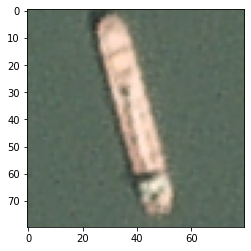

In [73]:
plt.imshow(sn_patches[100])

Resample the patches so they match the Sentinel-2 resolution

In [0]:
sn_patches_resize = np.zeros([sn_patches.shape[0],
                            PATCH_SIZE,
                            PATCH_SIZE,
                            sn_patches.shape[3]])

In [0]:
for img in range(sn_patches.shape[0]):
  sn_patches_resize[img] = resize(sn_patches[img], [PATCH_SIZE, PATCH_SIZE])

((4000, 32, 32, 3), <matplotlib.image.AxesImage at 0x7fa59ec8ecf8>)

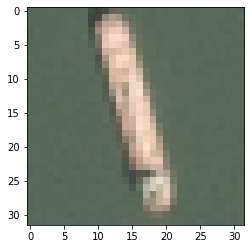

In [76]:
sn_patches_resize.shape, plt.imshow(sn_patches_resize[100])

In [77]:
sn_patches_resize.min(), sn_patches_resize.max()

(0.00514705882352943, 0.996078431372549)

In [78]:
#Prepare Data
x_train, x_test, y_train, y_test = train_test_split(sn_patches_resize, 
                                                    shipsnet['labels'], 
                                                    stratify=shipsnet['labels'], 
                                                    test_size=0.4, 
                                                    random_state=42)

np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([1800,  600])), (array([0, 1]), array([1200,  400])))

In [79]:
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# y_train = y_train.astype('int')
# y_test = y_test.astype('int')
num_classes = 2
y_train = to_categorical(y_train, num_classes, dtype='int')
y_test = to_categorical(y_test, num_classes, dtype='int')

2400 train samples
1600 test samples


# Train Models on Kaggle Data

## Train Model 1: SVM
Train an SVM model on a balanced Shipsnet dataset

Flatten the data for SVM.

In [0]:
x_svm = sn_patches_resize.reshape([sn_patches_resize.shape[0],
                    sn_patches_resize.shape[1] *
                    sn_patches_resize.shape[2] *
                    sn_patches_resize.shape[3]])

y_svm = np.array(shipsnet['labels'])

Balance the dataset

In [0]:
indPos = np.where(y_svm==1)[0]
indNeg = shuffle(np.where(y_svm==0)[0], random_state=123)[0:indPos.shape[0]]
indBal = shuffle(np.concatenate([indPos,indNeg]), random_state=123)

x_svm = x_svm[indBal, :]
y_svm = y_svm[indBal]

In [0]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_svm, 
                                                    y_svm, 
                                                    stratify = y_svm, 
                                                    test_size=0.4, 
                                                    random_state=42)

In [83]:
# train SVM
svc = svm.SVC(verbose=1)
svc.fit(x_train_svm, y_train_svm)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [0]:
# Test fitted SVM
yPred_svm = svc.predict(x_test_svm)
yTrainPred_svm = svc.predict(x_train_svm)
yProb_svm = svc.decision_function(x_test_svm)
fpr, tpr, thresh = roc_curve(y_test_svm, yProb_svm)
aucVal = auc(fpr, tpr)

In [85]:
# Accuracy
print('Test Accuracy: ' + str(100 * np.sum(yPred_svm==y_test_svm) / y_test_svm.shape[0]))
print('Train Accuracy: ' + str(100 * np.sum(yTrainPred_svm==y_train_svm) / y_train_svm.shape[0]))
print('AUC: ' + str(aucVal))

Test Accuracy: 94.25
Train Accuracy: 97.41666666666667
AUC: 0.98686875


Use GridSearchCV to optimize hyperparameters

In [86]:
# Optimize hyperparameters for 
svc = svm.SVC(verbose=1)

param_grid = {'kernel':('linear', 'sigmoid', 'rbf'), 
              'C': [1, 10, 100], 
              'gamma': ('scale', 'auto')}

search = GridSearchCV(svc, param_grid, 
                      verbose = 10,
                      n_jobs = -1,
                      cv = 10).fit(x_train_svm, y_train_svm)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

[LibSVM]

In [87]:
M1 = search.best_estimator_
M1

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [0]:
%%capture
# Outer 10-fold CV
nested_score = cross_val_score(M1, X=x_test_svm, y=y_test_svm, cv=10)
mean_accuracy = nested_score.mean()

In [89]:
print("Mean Accuracy (10-fold CV): " + str(mean_accuracy))
print("Maximum Fold Accuracy: " + str(nested_score.max()))
print("Minimum Fold Accuracy: " + str(nested_score.min()))

Mean Accuracy (10-fold CV): 0.945
Maximum Fold Accuracy: 0.975
Minimum Fold Accuracy: 0.875


## Train Model 2: Shallow CNN
This model includes a single convolutional layer, a single dense layer and relatively minor data augmentation.

In [0]:
M2 = Sequential()
M2.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
M2.add(Flatten())
M2.add(Dense(num_classes, activation='softmax'))

In [0]:
M2.compile(loss='categorical_crossentropy',
              optimizer=adam(),
              metrics=['accuracy'])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [93]:
#train the model
history = M2.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/500
18/18 [==============================] - 1s 46ms/step - loss: 0.6175 - accuracy: 0.7540 - val_loss: 0.4762 - val_accuracy: 0.8262
Epoch 2/500
18/18 [==============================] - 1s 51ms/step - loss: 0.4292 - accuracy: 0.8129 - val_loss: 0.4045 - val_accuracy: 0.8397
Epoch 3/500
18/18 [==============================] - 1s 50ms/step - loss: 0.3597 - accuracy: 0.8411 - val_loss: 0.3576 - val_accuracy: 0.8458
Epoch 4/500
18/18 [==============================] - 1s 50ms/step - loss: 0.3463 - accuracy: 0.8521 - val_loss: 0.3539 - val_accuracy: 0.8777
Epoch 5/500
18/18 [==============================] - 1s 50ms/step - loss: 0.2985 - accuracy: 0.8720 - val_loss: 0.2457 - val_accuracy: 0.8913
Epoch 6/500
18/18 [==============================] - 1s 51ms/step - loss: 0.2784 - accuracy: 0.8830 - val_loss: 0.2550 - val_accuracy: 0.8906
Epoch 7/500
18/18 [==============================] - 1s 50ms/step - loss: 0.2617 - accuracy: 0.8963 - val_loss: 0.2360 - val_accuracy: 0.8770
Epoch 

In [94]:
#Evaluating Shipsnet test loss and test accuracy
score2 = M2.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score2[0])
print('Shipsnet Test accuracy:', score2[1])

Shipsnet Test loss: 0.07143062138929963
Shipsnet Test accuracy: 0.9737499952316284


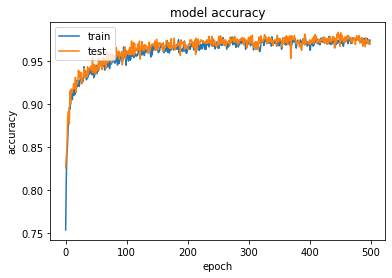

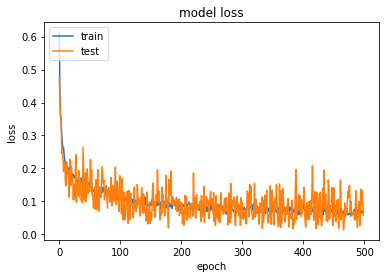

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Train Model 3: Deep Convnet
This model includes more layers, callbacks, and more aggressive data augmentation.

In [0]:
# Structure Model
M3 = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
                 Dropout(0.20),
                 Conv2D(64, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #12x12
                 Dropout(0.20),
                 Conv2D(128, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #6x6
                 Conv2D(512, (3, 3), padding='same', activation='softmax'),
                 MaxPooling2D(pool_size=(2, 2)), #3x3
                 Dropout(0.20),
                 Flatten(),
                 Dense(512, activation='relu'),
                 Dropout(0.20),
                #  Dense(512, activation='softmax'),
                 Dense(2, activation='softmax')])

In [97]:
M3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)        

In [0]:
# model_file = DRIVE_PATH + 'models/M3.h5'

early_stop = EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 50, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = ReduceLROnPlateau(monitor = 'val_loss',
                              verbose = 1,
                              factor = 0.1,
                              patience = 15) # to make sure early_stop is what stops the model

# checkpoint = ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

callback_list = [reduce_LR, 
                #  checkpoint,
                 early_stop]

In [0]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [0]:
optimizer = adam()
lr_metric = get_lr_metric(optimizer)

M3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range=0.1,
    zoom_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='reflect')

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [102]:
#train the model
history = M3.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128,
    callbacks = callback_list)

Epoch 1/500
18/18 [==============================] - 1s 55ms/step - loss: 0.5910 - accuracy: 0.7447 - lr: 0.0010 - val_loss: 0.6148 - val_accuracy: 0.7513 - val_lr: 0.0010
Epoch 2/500
18/18 [==============================] - 1s 58ms/step - loss: 0.5550 - accuracy: 0.7566 - lr: 0.0010 - val_loss: 0.6008 - val_accuracy: 0.7486 - val_lr: 0.0010
Epoch 3/500
18/18 [==============================] - 1s 61ms/step - loss: 0.5724 - accuracy: 0.7443 - lr: 0.0010 - val_loss: 0.5498 - val_accuracy: 0.7452 - val_lr: 0.0010
Epoch 4/500
18/18 [==============================] - 1s 56ms/step - loss: 0.5654 - accuracy: 0.7482 - lr: 0.0010 - val_loss: 0.5458 - val_accuracy: 0.7473 - val_lr: 0.0010
Epoch 5/500
18/18 [==============================] - 1s 56ms/step - loss: 0.5665 - accuracy: 0.7474 - lr: 0.0010 - val_loss: 0.5098 - val_accuracy: 0.7602 - val_lr: 0.0010
Epoch 6/500
18/18 [==============================] - 1s 61ms/step - loss: 0.5666 - accuracy: 0.7487 - lr: 0.0010 - val_loss: 0.5412 - val_ac

In [103]:
#Evaluating Shipsnet test loss and test accuracy
score3 = M3.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score3[0])
print('Shipsnet Test accuracy:', score3[1])

Shipsnet Test loss: 0.10138689631596208
Shipsnet Test accuracy: 0.9618750214576721


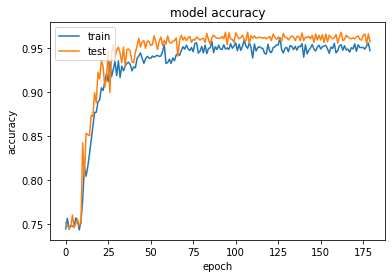

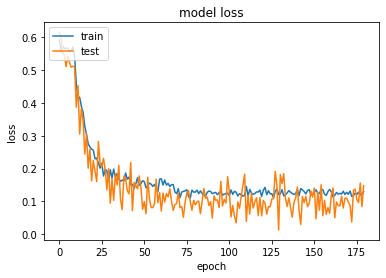

In [104]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Train Model 4: Transfer Learning
Here, we tried to incorporate several different pre-trained models, and we found that the [DenseNet121](https://github.com/liuzhuang13/DenseNet) model delivered the best results.

In [0]:
base_model = 'DenseNet121'

In [0]:
from keras.applications.densenet import DenseNet169 as base, preprocess_input

In [107]:
conv_base = base(include_top=False,
            input_shape = (PATCH_SIZE, PATCH_SIZE, 3))

conv_base.trainable = False


51879936/51877672 [==============================] - 4s 0us/step


In [108]:
conv_base.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [0]:
# model_file = DRIVE_PATH + 'models/M4.h5'

early_stop = EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 50, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = ReduceLROnPlateau(monitor = 'val_loss',
                              verbose = 1,
                              factor = 0.1,
                              patience = 15) # to make sure early_stop is what stops the model

# checkpoint = ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

callback_list = [reduce_LR, 
                #  checkpoint,
                 early_stop]

In [110]:
M4 = Sequential()

M4.add(conv_base)

M4.add(Flatten())
M4.add(Dense(512, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(2, activation='sigmoid'))

M4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 1, 1, 1664)        12642880  
_________________________________________________________________
flatten_4 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               852480    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 1026      
Total params: 13,496,386
Trainable params: 853,506
Non-trainable params: 12,642,880
_________________________________________________________________


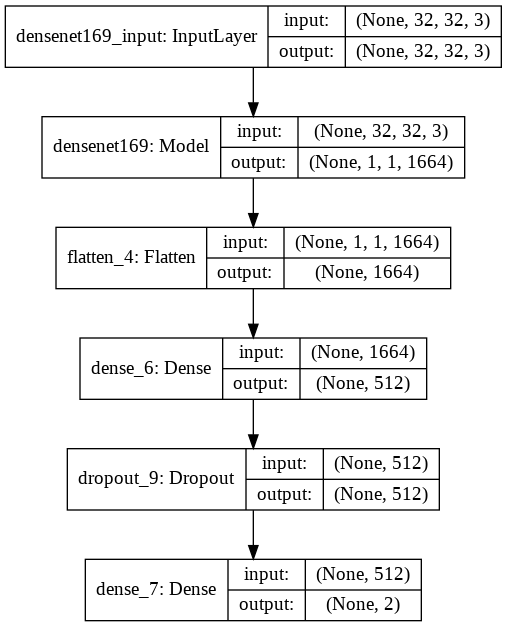

In [111]:
plot_model(M4, show_shapes=True, show_layer_names=True)

In [112]:
optimizer = adam()
lr_metric = get_lr_metric(optimizer)

M4.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range=0.1,
    zoom_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='reflect')

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [114]:
history = M4.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128,
    callbacks = callback_list)

Epoch 1/500
18/18 [==============================] - 8s 434ms/step - loss: 0.5658 - accuracy: 0.7576 - lr: 0.0010 - val_loss: 0.4368 - val_accuracy: 0.7630 - val_lr: 0.0010
Epoch 2/500
18/18 [==============================] - 2s 113ms/step - loss: 0.3258 - accuracy: 0.8538 - lr: 0.0010 - val_loss: 0.4138 - val_accuracy: 0.7796 - val_lr: 0.0010
Epoch 3/500
18/18 [==============================] - 2s 89ms/step - loss: 0.2602 - accuracy: 0.8869 - lr: 0.0010 - val_loss: 0.4451 - val_accuracy: 0.7918 - val_lr: 0.0010
Epoch 4/500
18/18 [==============================] - 2s 87ms/step - loss: 0.2661 - accuracy: 0.8948 - lr: 0.0010 - val_loss: 0.5101 - val_accuracy: 0.7677 - val_lr: 0.0010
Epoch 5/500
18/18 [==============================] - 2s 86ms/step - loss: 0.2459 - accuracy: 0.9076 - lr: 0.0010 - val_loss: 0.3777 - val_accuracy: 0.7629 - val_lr: 0.0010
Epoch 6/500
18/18 [==============================] - 1s 80ms/step - loss: 0.2293 - accuracy: 0.9051 - lr: 0.0010 - val_loss: 0.4341 - val_

In [115]:
#Evaluating Shipsnet test loss and test accuracy
score4 = M4.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score4[0])
print('Shipsnet Test accuracy:', score4[1])

Shipsnet Test loss: 0.42474941492080687
Shipsnet Test accuracy: 0.7871875166893005


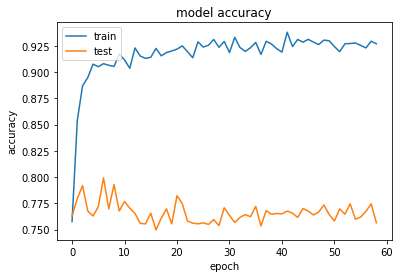

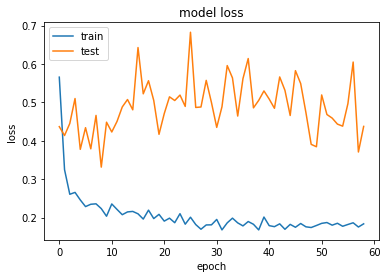

In [118]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Download Sentinel-2 Data

## Sentinel Hub API

In [0]:
## Sentinel API Query
#api = SentinelAPI(SENTINEL_USER, SENTINEL_PWD, 'https://scihub.copernicus.eu/dhus')

#scenes = api.to_geodataframe(api.query(tileid=TILE_ID,
                                            #  date=('20100101','NOW'),
                                            #  platformname='Sentinel-2',
                                            #  cloudcoverpercentage=(0, 6)))
#get full scene metadata
#tempList = list()
#for uuid in scenes.uuid:
  #tempList.append(api.get_product_odata(uuid, full=True))

#sceneMeta = pd.DataFrame(tempList)
#sceneMeta = sceneMeta.loc[sceneMeta['Online'] == True] # filter out images that are in Long Term Archive and have a 30 minute throttle to download

#sceneMeta

In [0]:
## download sentinel images available online
#for index, row in sceneMeta.iterrows():
  #uuid = row['id']
  #title = row['title']
  #filename = row['Filename']
  #print(f'Downloading {title}')
  #api.download(uuid)

In [0]:
## Unzip folders
## this creates SAFE files/directories which are explained here: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats
#for index, row in sceneMeta.iterrows(): 
    #title = row['title']
    #filename = row['Filename']
    #print(f'Unzipping {title}')
    #with zipfile.ZipFile(title+'.zip', 'r') as safezip:
      #safezip.extractall(filename)

In [0]:
#image_paths = []
#for index, row in sceneMeta.iterrows():
  #image_paths.append(extract_rgb_jp2(row['Filename'], row['title']))
#print(image_paths)

In [0]:
## delete unneeded files to free up space
#for name in sceneMeta.title:
  #if os.path.exists(name+'.zip'):
    #print(f'Deleting {name}.zip')
    #os.remove(name+'.zip')
  #if os.path.exists(name+'.SAFE'):
    #print(f'Deleting {name}.SAFE')
    #shutil.rmtree(name+'.SAFE')

## Google Drive Direct Download

In [0]:
sentinel_file_ids = {
    'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.jp2':'1s6yyxxp1tuON-OztYRWi3VxZyQgU5j5x',
    'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.jp2':'1sSafqtDo9Uj6VByj7XGmyzAMOHEF52kz',
    'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.jp2':'1DVWkhY2jmjZmdNNDCYF-J33n8CG-F6lG',
    'S2B_MSIL1C_20190406T031549_N0207_R118_T48NUG_20190406T073031.geojson':'14eT7PTG0NZzMVJVzwSe35KF7r6N27QnM',
    'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323.geojson':'1y3ZMhSMJTG0d6yBm6mdK4_y8iugpGBOu',
    'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736.geojson':'11BmAdav1tYnFe9Lr84Dh2TglGswzSA3m'
}

In [0]:
for file_name, file_id in sentinel_file_ids.items():
  download_file_from_google_drive(file_id, file_name)

# Prepare Sentinel-2 for Modeling

In [0]:
# Used with API method
# load ship points and scene
# scene_name = sceneMeta.title[0]
# ship_points = gpd.read_file(DRIVE_PATH+scene_name+'_SHIPS.geojson')
# sat_img = rio.open(scene_name+'.jp2')

In [0]:
# Used with Google Drive Method
# load ship points and scene
scene_name = 'S2A_MSIL1C_20191227T032131_N0208_R118_T48NUG_20191227T060736' 
ship_points = gpd.read_file(scene_name+'.geojson')
sat_img = rio.open(scene_name+'.jp2')

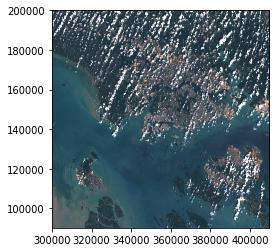

In [128]:
show(sat_img)

In [129]:
sentinel_patch_classes = patch_intersects_ship_buffers(ships = ship_points, 
                                                       img=sat_img, 
                                                       patch_size=PATCH_SIZE, 
                                                       step_size=STEP_SIZE)

100% (471969 of 471969) |################| Elapsed Time: 0:13:52 Time:  0:13:52


In [130]:
sentinel_patch_classes.groupby('isShip')['isShip'].count()

isShip
False    468644
True        581
Name: isShip, dtype: int64

In [0]:
frac = 0.1

sentinel_sample = (sentinel_patch_classes
                   .groupby('isShip', # stratify by isShip
                            group_keys = False)
                   .apply(lambda x: x.sample(frac = frac, # sample by group
                                             random_state = 123))
                   .sort_index()) # the index needs to be sorted for the sample patches to "line up" with `sentinel_sample`

In [132]:
sentinel_sample.groupby('isShip')['isShip'].count()

isShip
False    46864
True        58
Name: isShip, dtype: int64

In [133]:
sentinel_sample.head()

,isShip,x,y,patch_size
9,False,144,0,32
10,False,160,0,32
11,False,176,0,32
46,False,736,0,32
51,False,816,0,32


# Evaluate Models
Evaluate the four models on sentinel-2 and visualize the types of errors.

## Model 1

In [134]:
m1_pred_classes = classify_patches_svm(M1, sat_img, sentinel_sample)
m1_eval = evaluate_model(sentinel_sample, m1_pred_classes)

100% (46922 of 46922) |##################| Elapsed Time: 0:01:33 Time:  0:01:33


True Positive: 5
True Negative: 46652
False Positive: 212
False Negative: 53
Specificity: 0.9955
Sensitivity: 0.0862
Precision: 0.023
Accuracy: 0.9944
Prevalence: 0.0012
Positive Predictive Value: 0.023


In [0]:
#plot_results(m1_eval, 'True Positive', sat_img, rows=1, cols =5)

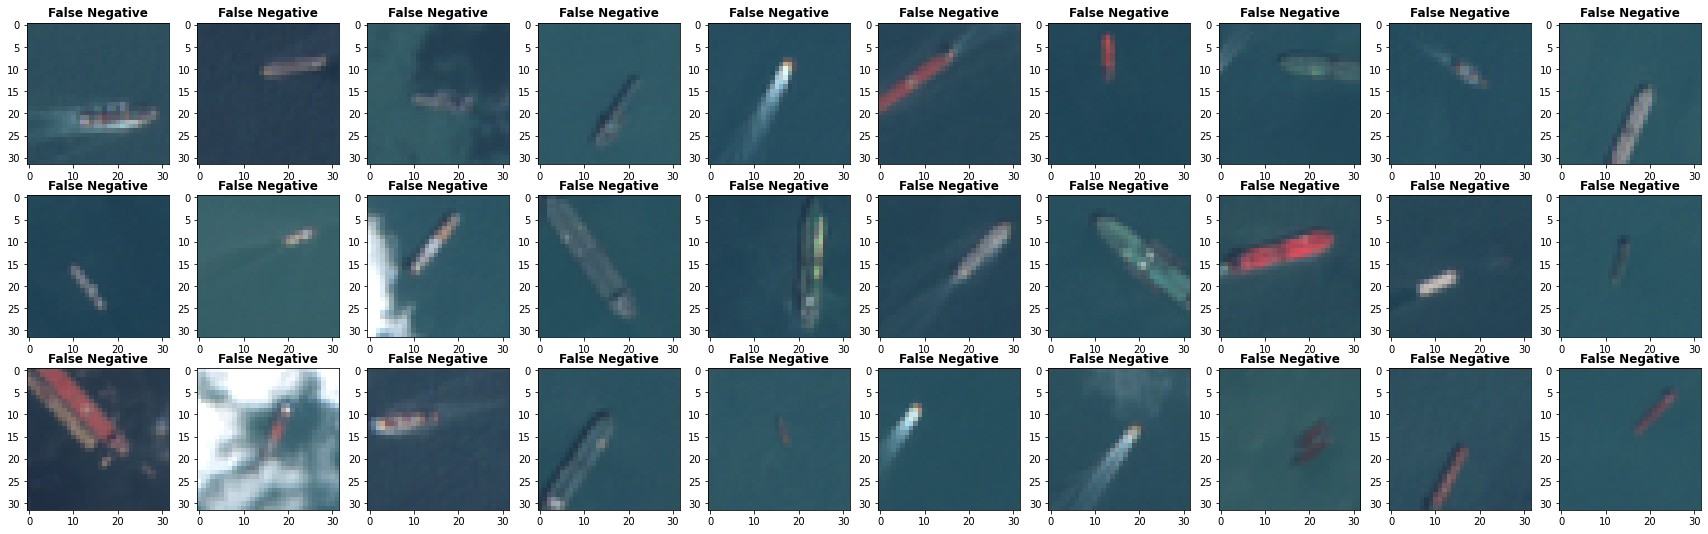

In [136]:
plot_results(m1_eval, 'False Negative', sat_img, rows=3, cols =10)

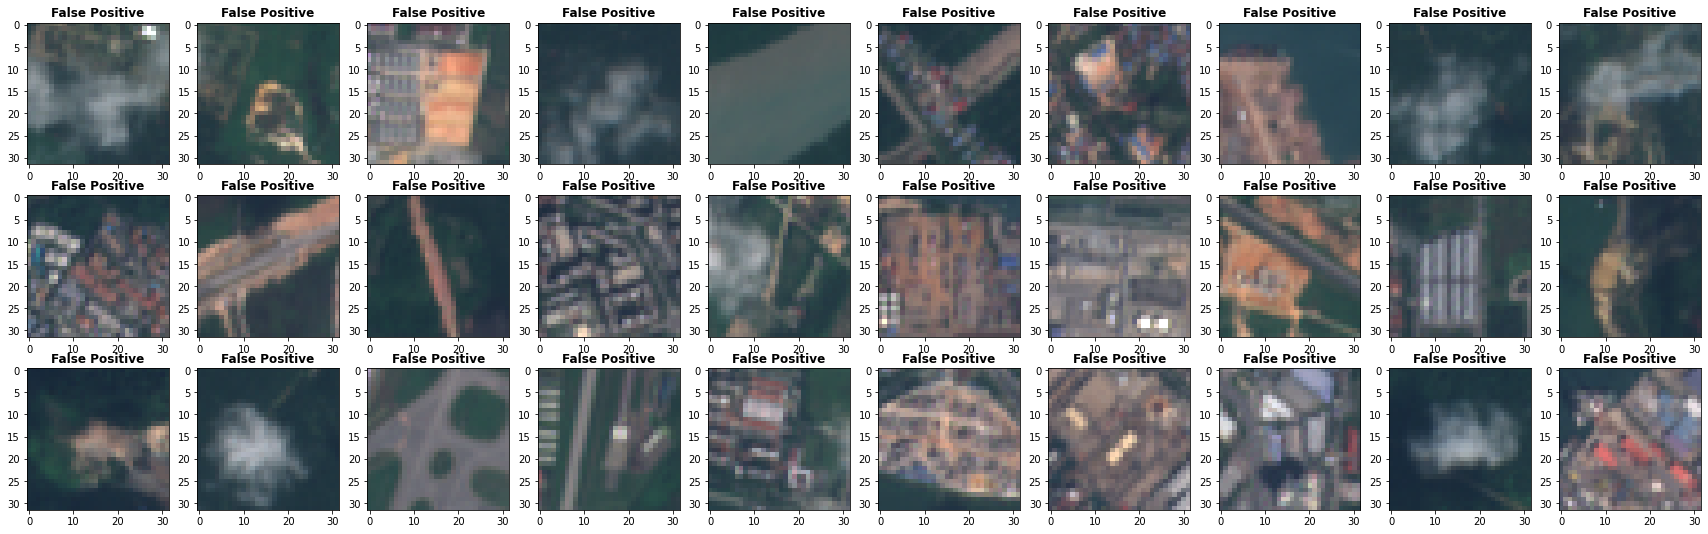

In [137]:
plot_results(m1_eval, 'False Positive', sat_img, rows=3, cols =10)

## Model 2

In [138]:
m2_pred_classes = classify_patches(M2, sat_img, sentinel_sample)
m2_eval = evaluate_model(sentinel_sample, m2_pred_classes)

100% (46922 of 46922) |##################| Elapsed Time: 0:01:34 Time:  0:01:34


True Positive: 3
True Negative: 46835
False Positive: 29
False Negative: 55
Specificity: 0.9994
Sensitivity: 0.0517
Precision: 0.0938
Accuracy: 0.9982
Prevalence: 0.0012
Positive Predictive Value: 0.0938


In [0]:
# plot_results(m2_eval, 'True Positive', sat_img, rows=1, cols =4)

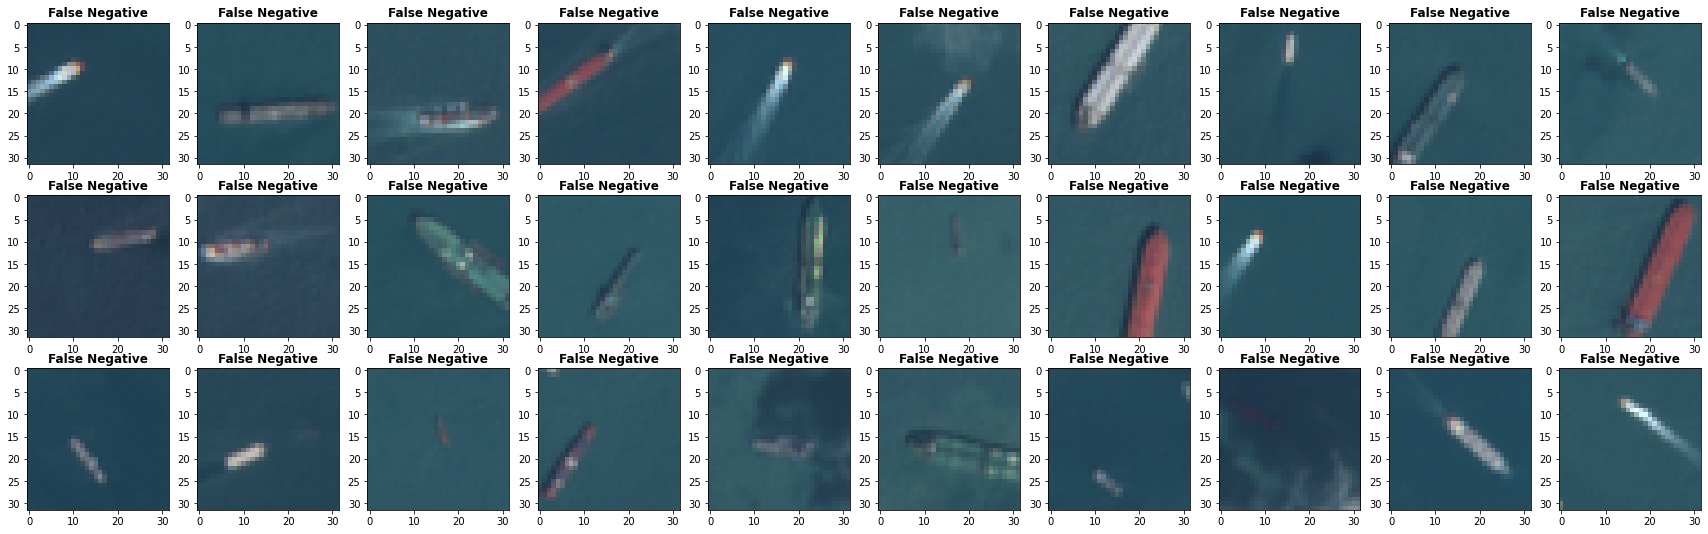

In [140]:
plot_results(m2_eval, 'False Negative', sat_img, rows=3, cols =10)

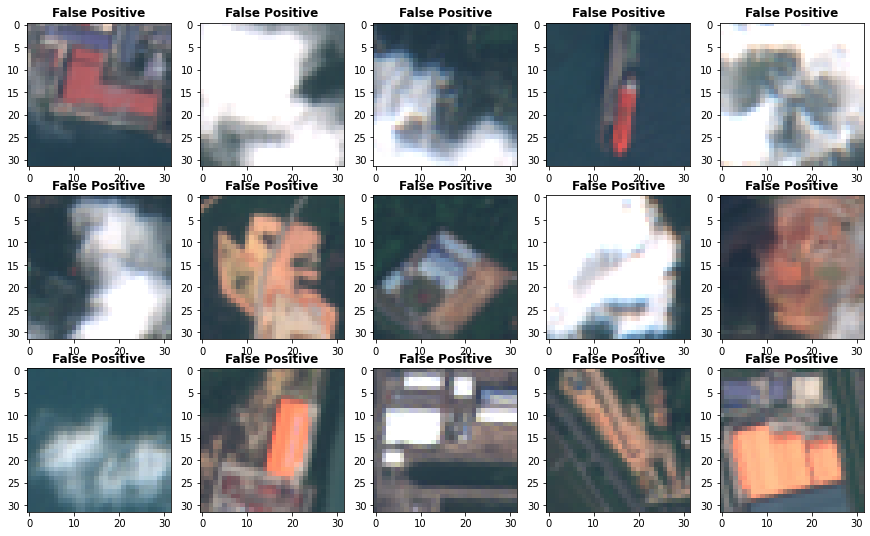

In [142]:
plot_results(m2_eval, 'False Positive', sat_img, rows=3, cols =5)

## Model 3

In [143]:
m3_pred_classes = classify_patches(M3, sat_img, sentinel_sample)
m3_eval = evaluate_model(sentinel_sample, m3_pred_classes)

100% (46922 of 46922) |##################| Elapsed Time: 0:01:54 Time:  0:01:54


True Positive: 8
True Negative: 46746
False Positive: 118
False Negative: 50
Specificity: 0.9975
Sensitivity: 0.1379
Precision: 0.0635
Accuracy: 0.9964
Prevalence: 0.0012
Positive Predictive Value: 0.0635


In [0]:
# plot_results(m3_eval, 'True Positive', sat_img, rows=1, cols =6)

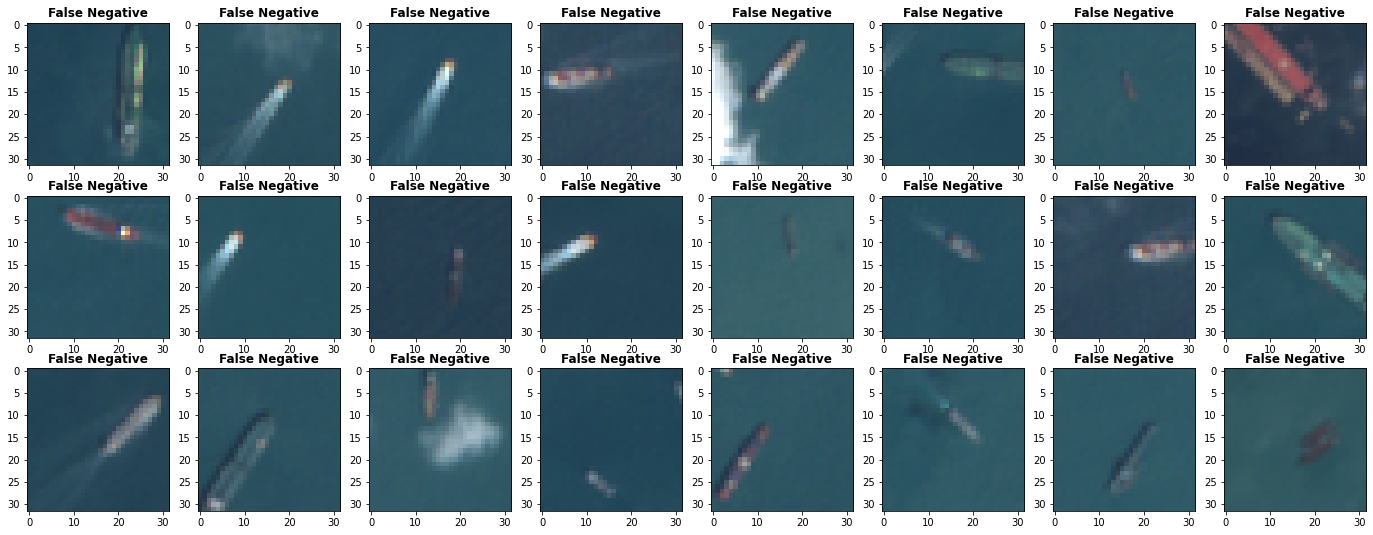

In [145]:
plot_results(m3_eval, 'False Negative', sat_img, rows=3, cols =8)

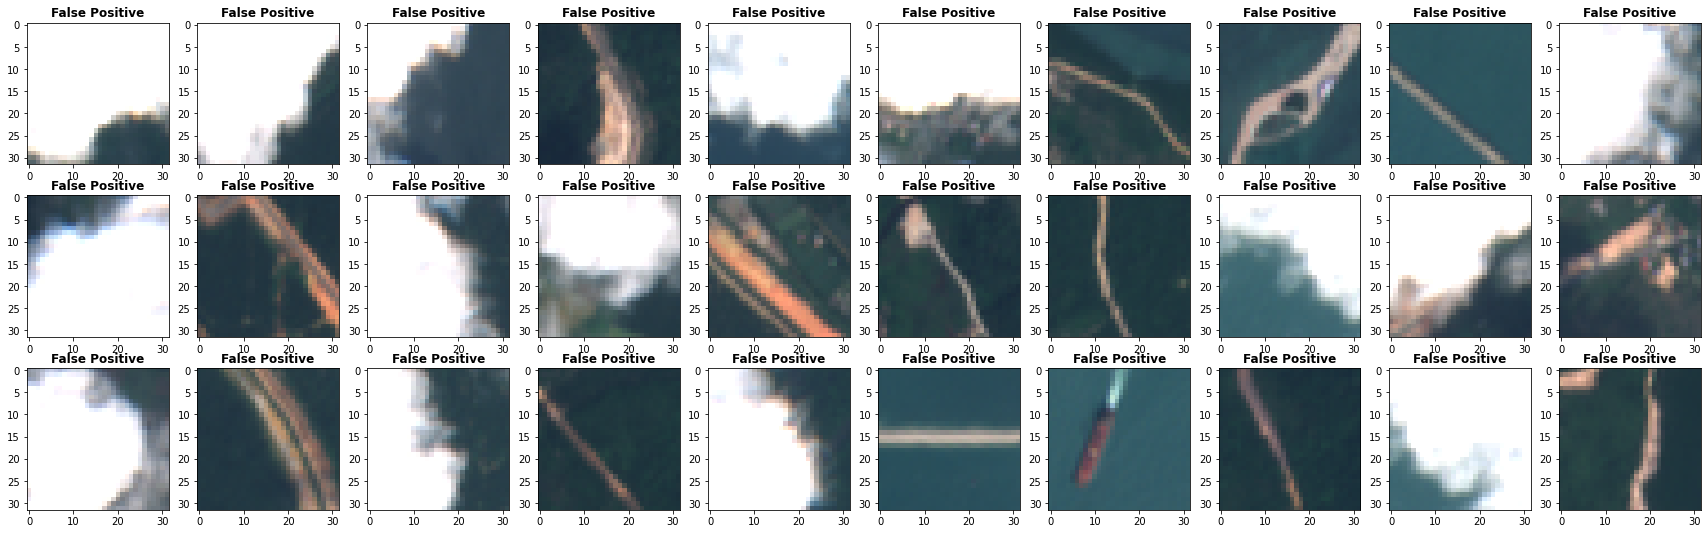

In [146]:
plot_results(m3_eval, 'False Positive', sat_img, rows=3, cols =10)

## Model 4

In [147]:
m4_pred_classes = classify_patches(M4, sat_img, sentinel_sample)
m4_eval = evaluate_model(sentinel_sample, m4_pred_classes)

100% (46922 of 46922) |##################| Elapsed Time: 0:20:31 Time:  0:20:31


True Positive: 17
True Negative: 41184
False Positive: 5680
False Negative: 41
Specificity: 0.8788
Sensitivity: 0.2931
Precision: 0.003
Accuracy: 0.8781
Prevalence: 0.0012
Positive Predictive Value: 0.003


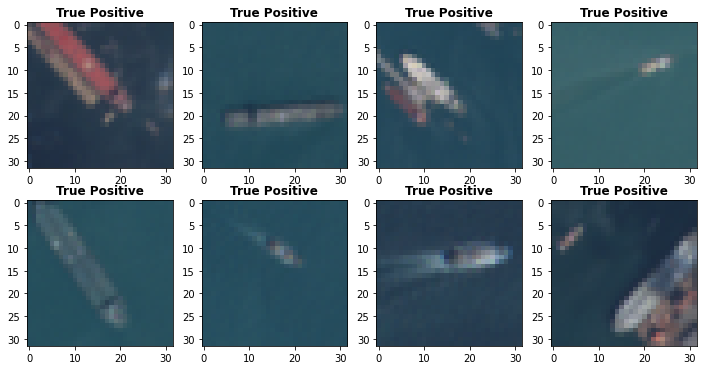

In [148]:
plot_results(m4_eval, 'True Positive', sat_img, rows=2, cols =4)

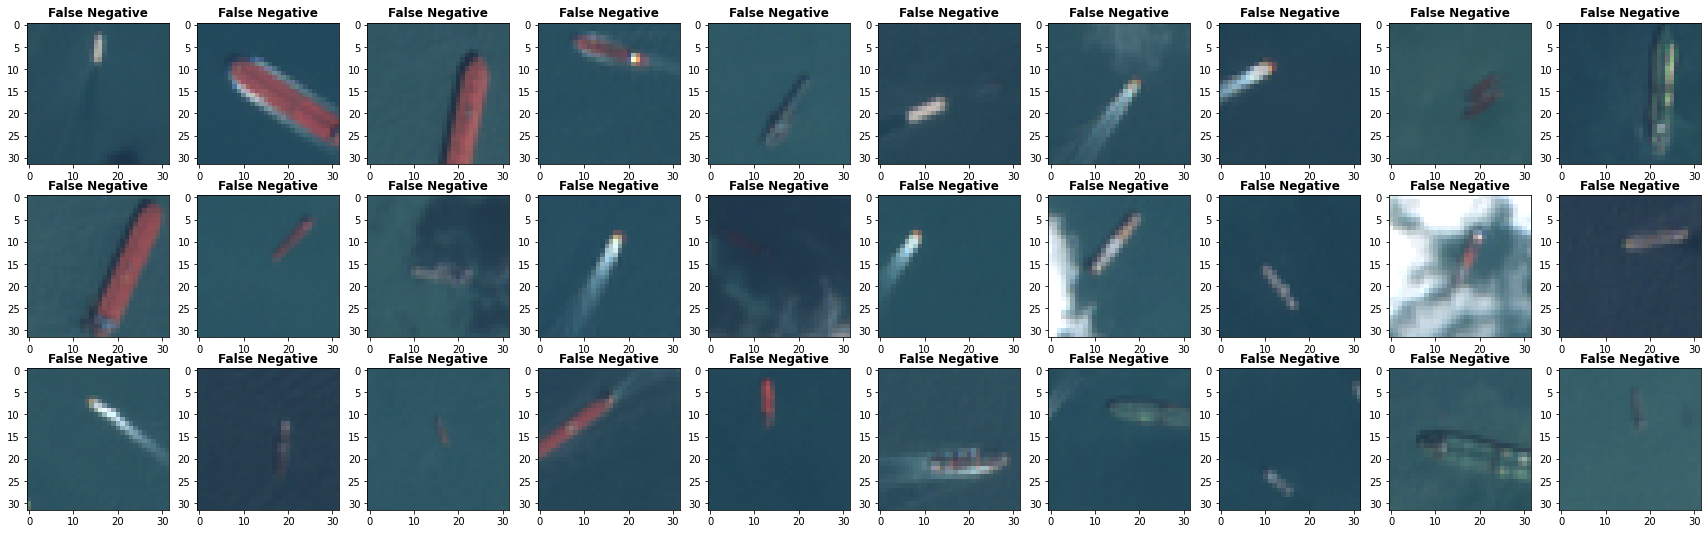

In [149]:
plot_results(m4_eval, 'False Negative', sat_img, rows=3, cols =10)

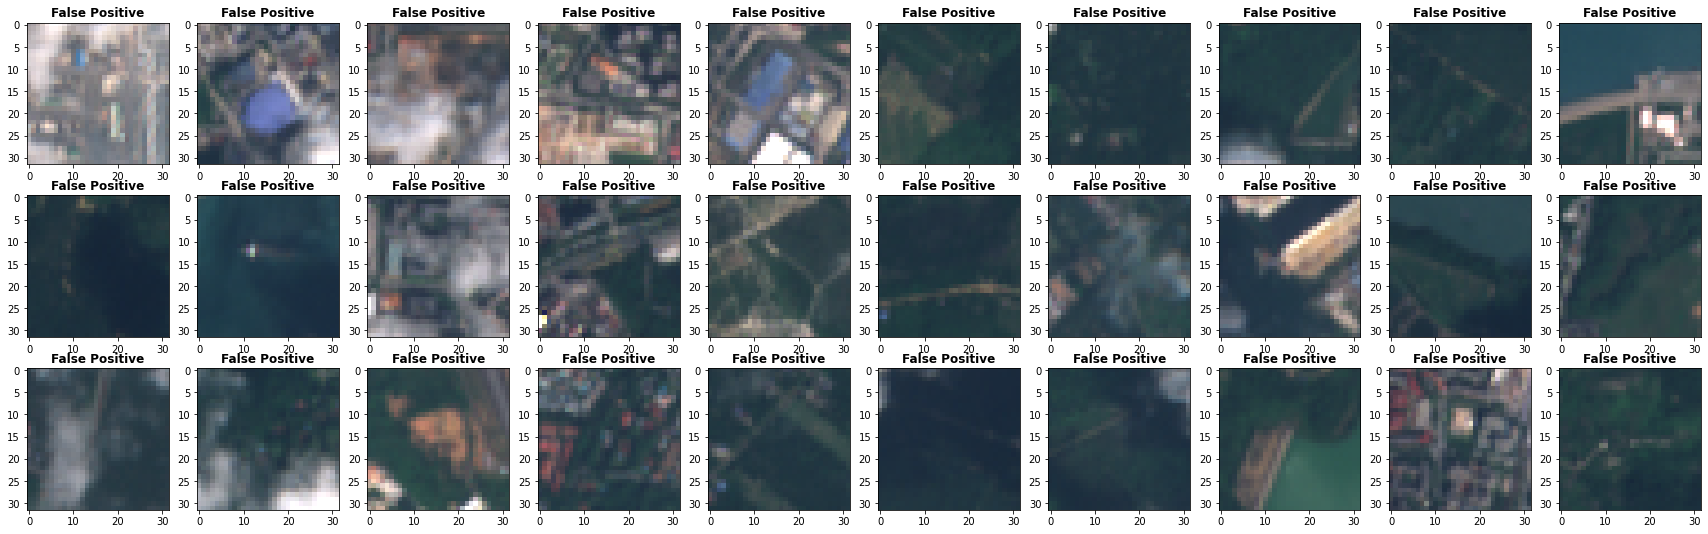

In [150]:
plot_results(m4_eval, 'False Positive', sat_img, rows=3, cols =10)

# Train Models on Sentinel-2 as Baselines

## Data Prep

Create a balanced sample of patches and store in memory.

In [0]:
indPos = np.where(sentinel_patch_classes['isShip']==True)[0]
indNeg = shuffle(np.where(sentinel_patch_classes['isShip']==False)[0], random_state=123)[0:indPos.shape[0]]
indBal = shuffle(np.concatenate([indPos,indNeg]), random_state=123)

In [0]:
sentinel_sample_y = sentinel_patch_classes.iloc[indBal].sort_index()

In [153]:
sentinel_sample_x = create_patches_sample(img=sat_img, 
                                                sample=sentinel_sample_y,
                                                patch_size=PATCH_SIZE,
                                                step_size=STEP_SIZE)

100% (471969 of 471969) |################| Elapsed Time: 0:00:01 Time:  0:00:01


In [154]:
sentinel_sample_y = sentinel_sample_y.reset_index(drop = True)
sentinel_sample_y.loc[sentinel_sample_y['isShip'] == True].head(10)

,isShip,x,y,patch_size
161,True,9008,2896,32
162,True,9024,2896,32
224,True,9232,3968,32
240,True,10128,4432,32
241,True,400,4448,32
242,True,10096,4448,32
243,True,10112,4448,32
247,True,9872,4480,32
248,True,9888,4480,32
258,True,128,4656,32


True


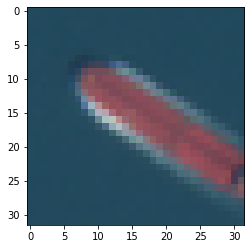

In [155]:
example = 258

print(sentinel_sample_y['isShip'][example])
plt.imshow(sentinel_sample_x[example]);

Load a 2nd scene for evaluating the models.

In [0]:
# load ship points and scene
# scene_name2 = sceneMeta.title[1]  # Used with API method
# ship_points2 = gpd.read_file(DRIVE_PATH+scene_name2+'_SHIPS.geojson')

In [0]:
# Used with Google Drive Method
scene_name2 = 'S2B_MSIL1C_20190705T031549_N0207_R118_T48NUG_20190705T065323' 

ship_points2 = gpd.read_file(scene_name2+'.geojson')
sat_img2 = rio.open(scene_name2+'.jp2')

In [158]:
sentinel_patch_classes_img2 = patch_intersects_ship_buffers(ships = ship_points2, 
                                                       img=sat_img2, 
                                                       patch_size=PATCH_SIZE, 
                                                       step_size=STEP_SIZE)

100% (471969 of 471969) |################| Elapsed Time: 0:11:27 Time:  0:11:27


In [159]:
sentinel_patch_classes_img2.groupby('isShip')['isShip'].count()

isShip
False    468777
True        448
Name: isShip, dtype: int64

In [0]:
frac = 0.1

sentinel_sample_img2 = (sentinel_patch_classes_img2
                   .groupby('isShip', # stratify by isShip
                            group_keys = False)
                   .apply(lambda x: x.sample(frac = frac, # sample by group
                                             random_state = 123))
                   .sort_index()) # the index needs to be sorted for the sample patches to "line up" with `sentinel_sample`

## Model 1

In [0]:
x_svm = sentinel_sample_x.reshape([sentinel_sample_x.shape[0],
                    sentinel_sample_x.shape[1] *
                    sentinel_sample_x.shape[2] *
                    sentinel_sample_x.shape[3]])

x_svm = np.interp(x_svm, (0,255), (0,1)) #remap values from (0,255) to (90,1)

y_svm = np.array(sentinel_sample_y['isShip'])

In [162]:
x_svm.min(), x_svm.max()

(0.00392156862745098, 1.0)

In [0]:
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(x_svm, 
                                                    y_svm, 
                                                    stratify = y_svm, 
                                                    test_size=0.4, 
                                                    random_state=42)

In [164]:
# train SVM
svc = svm.SVC(verbose=1)
svc.fit(x_train_svm, y_train_svm)

# Test fitted SVM
yPred_svm = svc.predict(x_test_svm)
yTrainPred_svm = svc.predict(x_train_svm)
yProb_svm = svc.decision_function(x_test_svm)
fpr, tpr, thresh = roc_curve(y_test_svm, yProb_svm)
aucVal = auc(fpr, tpr)

# Accuracy
print('Test Accuracy: ' + str(100 * np.sum(yPred_svm==y_test_svm) / y_test_svm.shape[0]))
print('Train Accuracy: ' + str(100 * np.sum(yTrainPred_svm==y_train_svm) / y_train_svm.shape[0]))
print('AUC: ' + str(aucVal))

[LibSVM]Test Accuracy: 79.35483870967742
Train Accuracy: 80.05738880918221
AUC: 0.8643443836021905


GridsearchCV

In [165]:
# Optimize hyperparameters for 
svc = svm.SVC(verbose=1)

param_grid = {'kernel':('linear', 'sigmoid', 'rbf'), 
              'C': [1, 10, 100], 
              'gamma': ('scale', 'auto')}

search = GridSearchCV(svc, param_grid, 
                      verbose = 10,
                      n_jobs = -1,
                      cv = 10).fit(x_train_svm, y_train_svm)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

[LibSVM]

In [166]:
M1_S = search.best_estimator_
M1_S

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

In [0]:
%%capture
# Outer 10-fold CV
nested_score = cross_val_score(M1_S, X=x_test_svm, y=y_test_svm, cv=10)
mean_accuracy = nested_score.mean()

In [168]:
print("Mean Accuracy (10-fold CV): " + str(mean_accuracy))
print("Maximum Fold Accuracy: " + str(nested_score.max()))
print("Minimum Fold Accuracy: " + str(nested_score.min()))

Mean Accuracy (10-fold CV): 0.8409805735430158
Maximum Fold Accuracy: 0.9347826086956522
Minimum Fold Accuracy: 0.7608695652173914


Test on 2nd scene

In [169]:
M1_S_pred_classes = classify_patches_svm(M1_S, sat_img2, sentinel_sample_img2)
M1_S_eval = evaluate_model(sentinel_sample_img2, M1_S_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:02:17 Time:  0:02:17


True Positive: 36
True Negative: 42547
False Positive: 4331
False Negative: 9
Specificity: 0.9076
Sensitivity: 0.8
Precision: 0.0082
Accuracy: 0.9075
Prevalence: 0.001
Positive Predictive Value: 0.0082


## Model 2

In [170]:
#Prepare Data
x_train, x_test, y_train, y_test = train_test_split(sentinel_sample_x, 
                                                    sentinel_sample_y.isShip, 
                                                    stratify=sentinel_sample_y.isShip,
                                                    test_size=0.5, 
                                                    random_state=42)

np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([False,  True]), array([290, 291])),
 (array([False,  True]), array([291, 290])))

In [171]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = y_train.astype('int')
y_test = y_test.astype('int')
num_classes = 2
y_train = to_categorical(y_train, num_classes, dtype='int')
y_test = to_categorical(y_test, num_classes, dtype='int')

581 train samples
581 test samples


In [0]:
M2_S = Sequential()
M2_S.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
M2_S.add(Flatten())
# M2.add(Dropout(0.20))
M2_S.add(Dense(num_classes, activation='softmax'))

In [0]:
M2_S.compile(loss='categorical_crossentropy',
              optimizer=adam(),
              metrics=['accuracy'])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360)

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [175]:
#train the model
history = M2_S.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128)

Epoch 1/500
4/4 [==============================] - 1s 261ms/step - loss: 0.9816 - accuracy: 0.5117 - val_loss: 1.4202 - val_accuracy: 0.4883
Epoch 2/500
4/4 [==============================] - 0s 67ms/step - loss: 0.9100 - accuracy: 0.5279 - val_loss: 0.8288 - val_accuracy: 0.4746
Epoch 3/500
4/4 [==============================] - 0s 75ms/step - loss: 0.7201 - accuracy: 0.5020 - val_loss: 0.6289 - val_accuracy: 0.6269
Epoch 4/500
4/4 [==============================] - 0s 48ms/step - loss: 0.6282 - accuracy: 0.6446 - val_loss: 0.7059 - val_accuracy: 0.5740
Epoch 5/500
4/4 [==============================] - 0s 31ms/step - loss: 0.6266 - accuracy: 0.6446 - val_loss: 0.6013 - val_accuracy: 0.6667
Epoch 6/500
4/4 [==============================] - 0s 67ms/step - loss: 0.6134 - accuracy: 0.6602 - val_loss: 0.6079 - val_accuracy: 0.6543
Epoch 7/500
4/4 [==============================] - 0s 76ms/step - loss: 0.5671 - accuracy: 0.7307 - val_loss: 0.5794 - val_accuracy: 0.6600
Epoch 8/500
4/4 [==

In [176]:
#Evaluating Shipsnet test loss and test accuracy
score2_S = M2_S.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score2_S[0])
print('Shipsnet Test accuracy:', score2_S[1])

Shipsnet Test loss: 0.24296379525361905
Shipsnet Test accuracy: 0.93459552526474


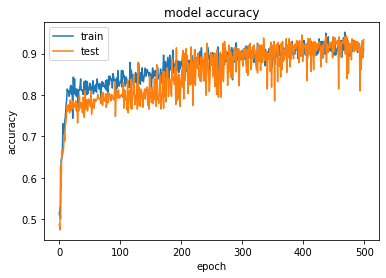

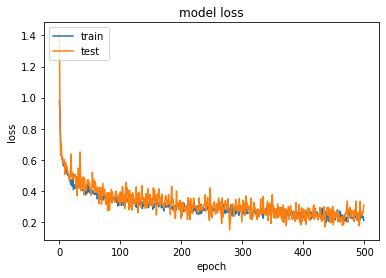

In [177]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test on 2nd scene.

In [178]:
M2_S_pred_classes = classify_patches(M2_S, sat_img2, sentinel_sample_img2)
M2_S_eval = evaluate_model(sentinel_sample_img2, M2_S_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:01:34 Time:  0:01:34


True Positive: 40
True Negative: 45273
False Positive: 1605
False Negative: 5
Specificity: 0.9658
Sensitivity: 0.8889
Precision: 0.0243
Accuracy: 0.9657
Prevalence: 0.001
Positive Predictive Value: 0.0243


## Model 3

In [0]:
# Structure Model
M3_S = Sequential([Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)),
                 Dropout(0.20),
                 Conv2D(64, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #12x12
                 Dropout(0.20),
                 Conv2D(128, (3, 3), padding='same', activation='relu'),
                 MaxPooling2D(pool_size=(2, 2)), #6x6
                 Conv2D(512, (3, 3), padding='same', activation='softmax'),
                 MaxPooling2D(pool_size=(2, 2)), #3x3
                 Dropout(0.20),
                 Flatten(),
                 Dense(512, activation='relu'),
                 Dropout(0.20),
                #  Dense(512, activation='softmax'),
                 Dense(2, activation='softmax')])

In [0]:
# model_file = DRIVE_PATH + 'models/M3_S.h5'

early_stop = EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 50, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = ReduceLROnPlateau(monitor = 'val_loss',
                              verbose = 1,
                              factor = 0.1,
                              patience = 15) # to make sure early_stop is what stops the model

# checkpoint = ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

callback_list = [reduce_LR, 
                #  checkpoint,
                 early_stop]

In [0]:
optimizer = adam()
lr_metric = get_lr_metric(optimizer)

M3_S.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range=0.1,
    zoom_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='reflect')

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [183]:
#train the model
history = M3_S.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128,
    callbacks = callback_list)

Epoch 1/500
4/4 [==============================] - 1s 358ms/step - loss: 0.6958 - accuracy: 0.4945 - lr: 0.0010 - val_loss: 0.6934 - val_accuracy: 0.5137 - val_lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 59ms/step - loss: 0.6937 - accuracy: 0.5293 - lr: 0.0010 - val_loss: 0.6960 - val_accuracy: 0.4702 - val_lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 72ms/step - loss: 0.7005 - accuracy: 0.4569 - lr: 0.0010 - val_loss: 0.6926 - val_accuracy: 0.4989 - val_lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 45ms/step - loss: 0.6944 - accuracy: 0.4824 - lr: 0.0010 - val_loss: 0.6954 - val_accuracy: 0.4746 - val_lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 47ms/step - loss: 0.6942 - accuracy: 0.4989 - lr: 0.0010 - val_loss: 0.6902 - val_accuracy: 0.5055 - val_lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 58ms/step - loss: 0.6924 - accuracy: 0.5188 - lr: 0.0010 - val_loss: 0.6951 - val_accuracy: 0.4

In [184]:
#Evaluating Shipsnet test loss and test accuracy
score3_S = M3_S.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score3_S[0])
print('Shipsnet Test accuracy:', score3_S[1])

Shipsnet Test loss: 0.14961674653006501
Shipsnet Test accuracy: 0.9535284042358398


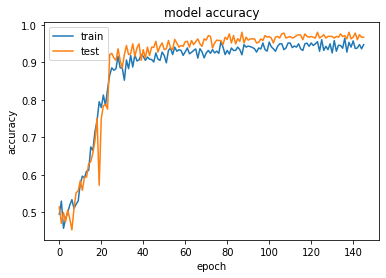

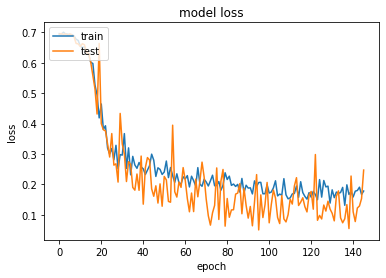

In [185]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test on 2nd scene.


In [186]:
M3_S_pred_classes = classify_patches(M3_S, sat_img2, sentinel_sample_img2)
M3_S_eval = evaluate_model(sentinel_sample_img2, M3_S_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:01:57 Time:  0:01:57


True Positive: 43
True Negative: 44035
False Positive: 2843
False Negative: 2
Specificity: 0.9394
Sensitivity: 0.9556
Precision: 0.0149
Accuracy: 0.9394
Prevalence: 0.001
Positive Predictive Value: 0.0149


## Model 4

In [0]:
# model_file = DRIVE_PATH + 'models/M4.h5'

early_stop = EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 50, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = ReduceLROnPlateau(monitor = 'val_loss',
                              verbose = 1,
                              factor = 0.1,
                              patience = 15) # to make sure early_stop is what stops the model

# checkpoint = ModelCheckpoint(filepath = model_file,
#                                              monitor = 'val_loss',
#                                              save_best_only = True)

callback_list = [reduce_LR,
                #  checkpoint,
                 early_stop]

In [0]:
M4_S = Sequential()

M4_S.add(conv_base)

M4_S.add(Flatten())
M4_S.add(Dense(512, activation='relu'))
M4_S.add(Dropout(0.2))
M4_S.add(Dense(2, activation='sigmoid'))

In [0]:
optimizer = adam()
lr_metric = get_lr_metric(optimizer)

M4_S.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
# data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range=0.1,
    zoom_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    fill_mode='reflect')

# data augmentation configuration for test data:
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=128)

In [191]:
history = M4_S.fit_generator(
    train_generator,
    steps_per_epoch=len(x_train) // 128,
    epochs=500,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 128,
    callbacks = callback_list)

Epoch 1/500
4/4 [==============================] - 8s 2s/step - loss: 0.8934 - accuracy: 0.5265 - lr: 0.0010 - val_loss: 0.7413 - val_accuracy: 0.5117 - val_lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 113ms/step - loss: 0.6660 - accuracy: 0.6446 - lr: 0.0010 - val_loss: 0.5798 - val_accuracy: 0.7230 - val_lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 101ms/step - loss: 0.4826 - accuracy: 0.7638 - lr: 0.0010 - val_loss: 0.5251 - val_accuracy: 0.7472 - val_lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 103ms/step - loss: 0.4243 - accuracy: 0.8486 - lr: 0.0010 - val_loss: 0.6365 - val_accuracy: 0.5806 - val_lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 75ms/step - loss: 0.4069 - accuracy: 0.8146 - lr: 0.0010 - val_loss: 0.5181 - val_accuracy: 0.7075 - val_lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 77ms/step - loss: 0.3777 - accuracy: 0.8350 - lr: 0.0010 - val_loss: 0.4534 - val_accuracy: 0.7

In [192]:
#Evaluating Shipsnet test loss and test accuracy
score4_S = M4_S.evaluate(x_test, y_test, verbose=0)
print('Shipsnet Test loss:', score4_S[0])
print('Shipsnet Test accuracy:', score4_S[1])

Shipsnet Test loss: 0.49673301781721657
Shipsnet Test accuracy: 0.7228915691375732


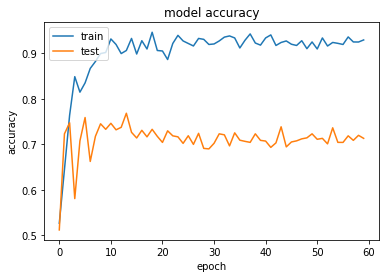

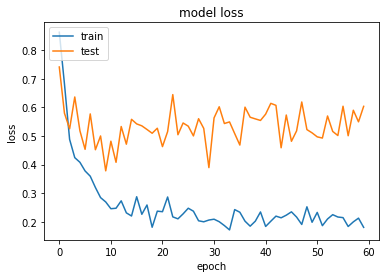

In [193]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Test on 2nd scene.

In [194]:
M4_S_pred_classes = classify_patches(M4_S, sat_img2, sentinel_sample_img2)
M4_S_eval = evaluate_model(sentinel_sample_img2, M4_S_pred_classes)

100% (46923 of 46923) |##################| Elapsed Time: 0:20:58 Time:  0:20:58


True Positive: 19
True Negative: 40155
False Positive: 6723
False Negative: 26
Specificity: 0.8566
Sensitivity: 0.4222
Precision: 0.0028
Accuracy: 0.8562
Prevalence: 0.001
Positive Predictive Value: 0.0028
